## Task example

Suppose a test was carried out in a number of cities during a certain period:
- In test cities, products are ranked by popularity on the website
- In all others, by increasing the price of the product

Questions:
1. What metrics could the test affect?
2. Do a visual analysis of the dataset. How do metrics behave over time? What are the distributions in the data?
3. How can you evaluate the effect of the test? If you know several methods, implement one and describe the others in writing. You need to make a decision/give recommendations to leave everything as is or roll out a test version to the entire network or part of it.
4. Speculate in writing what metrics could still be assessed if all the company data were available to you.

Dataset description:
- Date : date
- CityName : city
- OrderSource : order source - mp: mobile application, web: website, other - other
- Category: product category
- rto: revenue after discounts
- rto_do: revenue before discounts
- cost: costs of the cost of goods
- tickets: number of orders
- qty - number of products
- clients_qty - unique number of clients
- avg_time - average session time (only for those who placed an order)
- avg_price - average price

! In the original dataset, the data is already grouped by Date, CityName, OrderSource, Category

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from fitter import Fitter, get_common_distributions, get_distributions
import random
import logging
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
logging.getLogger().setLevel(logging.CRITICAL)

plt.rcParams['font.size'] = 14.0
plt.rcParams['figure.figsize'] = (10, 7)

In [3]:
df_all_data = pd.read_csv(r'../example.csv', encoding='utf8')
df_all_data.name = 'All Data'
df_all_data = df_all_data[df_all_data['Date'].between("2022-04-07T00:00:00.000Z", "2022-05-20T00:00:00.000Z")]

In [4]:
# print('Dataset information\n', df_all_data.info())
# print('Unique values\n', df_all_data.nunique())
# df_all_data.head()

df_test = df_all_data[df_all_data.CityName.isin(['Пенза', 'Уфа', 'Курск', 'Нижний' 'Тагил', 'Новокуйбышевск', 'Орск'])]
df_test.name = 'Test dataset'
#print(df_test.shape)

df = df_all_data[df_all_data.CityName.isin(set(df_test.CityName)) == False]
df.name = 'Original dataset'
#print(df.shape)

df.shape[0] + df_test.shape[0] == df_all_data.shape[0]

True

## Q:
1. What metrics could the test affect?

## A:
It is possible (!) that the test could affect the following metrics, and some of them may correlate with other indicators,
To do this, you can build a correlation matrix and understand what other metrics depend, among other things, on the parameters from steps 1-5:
1. avg_time, in test cities decreased for the website, because the most popular products are displayed there first
2. avg_price, if some of the popular products are more expensive than the average price, then the price has changed upward
3. tickets may have increased on the website because customers need less avg_time to place an order => higher purchase conversion
4. qty, the number of products has increased (dependence with avg_price)
5. clients_qty, the number of products has increased (dependence with avg_price)

Original dataset


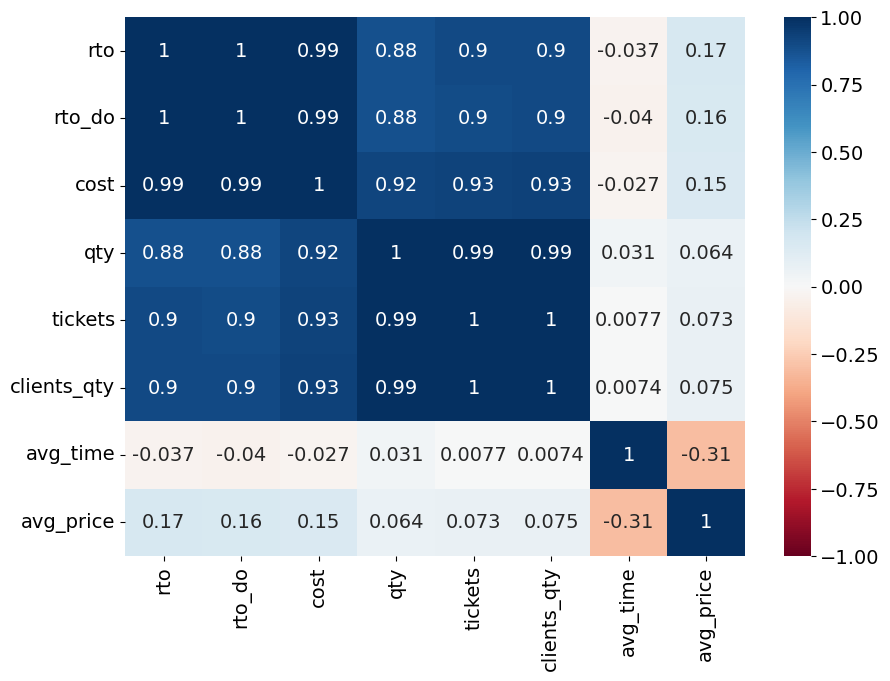

Test dataset


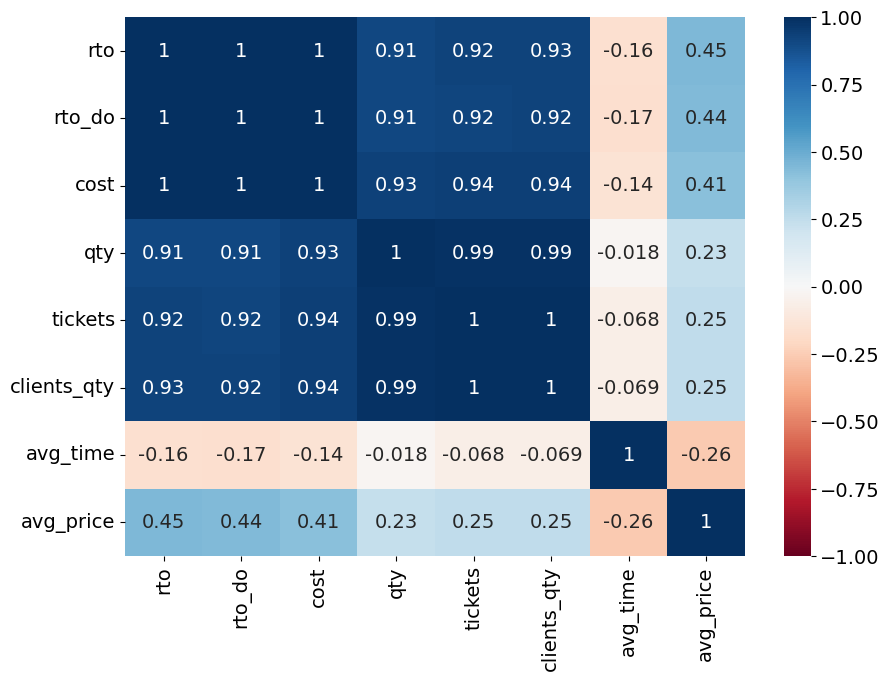

In [5]:
# Correlation matrix
def plot_correlation_matrix(dataset):
    sns.heatmap(dataset.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='RdBu')
    plt.show()
print("Original dataset")
plot_correlation_matrix(df)
print("Test dataset")
plot_correlation_matrix(df_test)

## Q:
2.
a). Do a visual analysis of the dataset. How do metrics behave over time?

b). What are the distributions in the data?
      
## A:
A visual analysis of the dataset was done.

In dynamics for weeks 1-6, the metrics are shown in the figures:
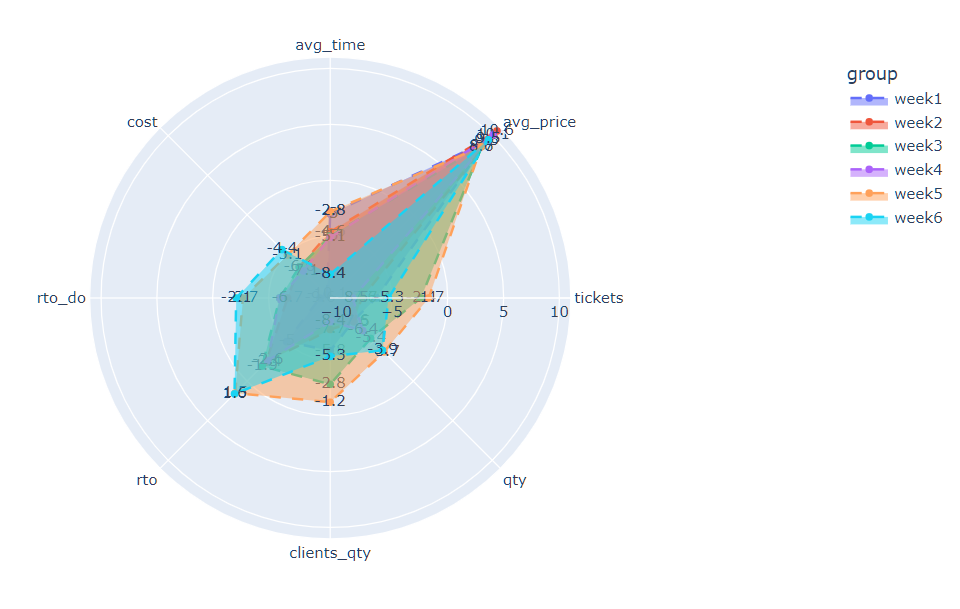
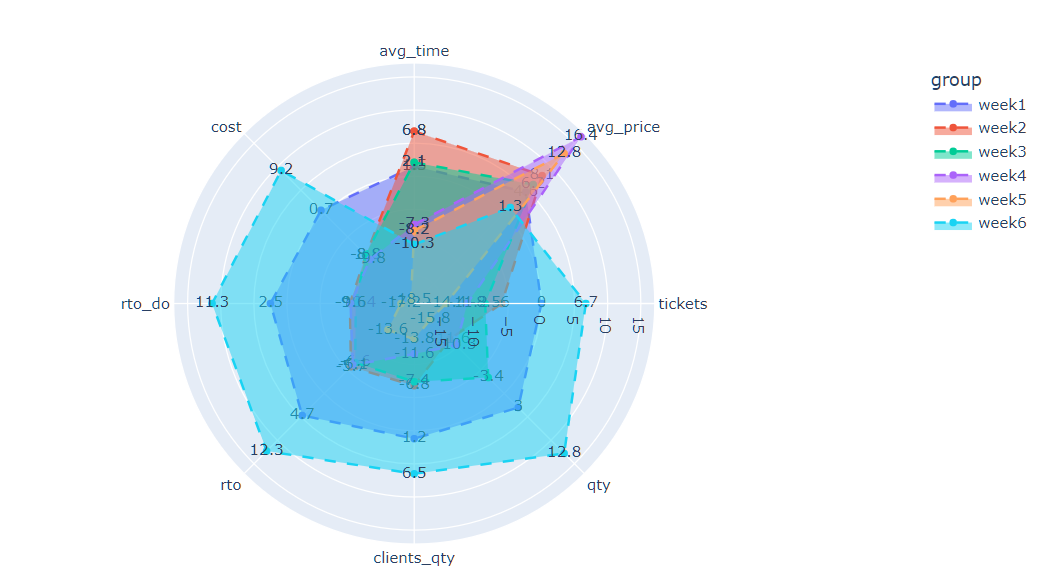

In [6]:
#a). Visual analysis of the dataset and metrics of differences in the original and test data sets (difference per week)
data_weekly = ["2022-04-07T00:00:00.000Z", "2022-04-14T00:00:00.000Z", "2022-04-21T00:00:00.000Z",
               "2022-04-28T00:00:00.000Z", "2022-05-05T00:00:00.000Z", "2022-05-12T00:00:00.000Z",
               "2022-05-19T00:00:00.000Z"]
variable = ['avg_time', 'avg_price', 'tickets', 'qty', 'clients_qty', 'rto', 'rto_do', 'cost']

values = []
def weekly(w1, w2):

    value = [round(np.mean(df[df['Date'].between(w1, w2) & df.OrderSource.eq('web')][i]) / 
                   np.mean(df_test[df_test['Date'].between(w1, w2) & df_test.OrderSource.eq('web')][i]) * 100 - 100, 1) for i in variable]

    for i in value:
        values.append(i)

weekly_data = []

for _, i in enumerate(range(len(data_weekly) - 1)):
    for i in range(len(variable)):
        weekly_data.append(f'week{_ + 1}')
    weekly(data_weekly[_], data_weekly[_ + 1])

#for i, j in zip(values, weekly_data):
df_analyze = pd.DataFrame(dict(
    value=values,
    variable = variable * (len(data_weekly) - 1),
    group = weekly_data))

fig = px.line_polar(df_analyze,
                    r = 'value',
                    theta = 'variable',
                    line_close = True,
                    text = 'value',
                    color = 'group',
                    line_dash_sequence = ['dash'])
fig.update_traces(fill = 'toself')
fig.show()

In [7]:
#a). Visual analysis of the dataset and metrics of differences in the original and test data sets (weekly average)

values = []
def weekly(w1):
    value = [round(np.mean(df[df['Date'].eq(w1) & df.OrderSource.eq('web')][i]) / 
                   np.mean(df_test[df_test['Date'].eq(w1) & df_test.OrderSource.eq('web')][i]) * 100 - 100, 1) for i in variable]

    for i in value:
        values.append(i)

weekly_data = []

for _, i in enumerate(range(len(data_weekly) - 1)):
    for i in range(len(variable)):
        weekly_data.append(f'week{_ + 1}')
    weekly(data_weekly[_])

#for i, j in zip(values, weekly_data):
df_analyze = pd.DataFrame(dict(
    value=values,
    variable = variable * (len(data_weekly) - 1),
    group = weekly_data))

fig = px.line_polar(df_analyze,
                    r = 'value',
                    theta = 'variable',
                    line_close = True,
                    text = 'value',
                    color = 'group',
                    line_dash_sequence = ['dash'])
fig.update_traces(fill = 'toself')
fig.show()

404 samples out of 42325 values


Fitting 111 distributions: 100%|█████████████████████████████████████████████████████| 111/111 [01:05<00:00,  1.69it/s]


The most suitable distribution for avg_time in Original dataset



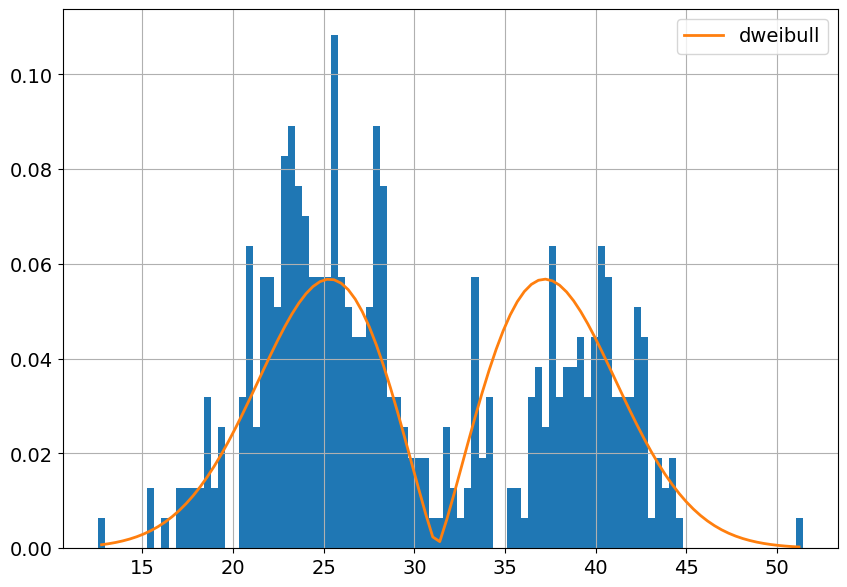

759 samples out of 846 values


Fitting 111 distributions: 100%|█████████████████████████████████████████████████████| 111/111 [04:55<00:00,  2.66s/it]


The most suitable distribution for avg_time in Test dataset



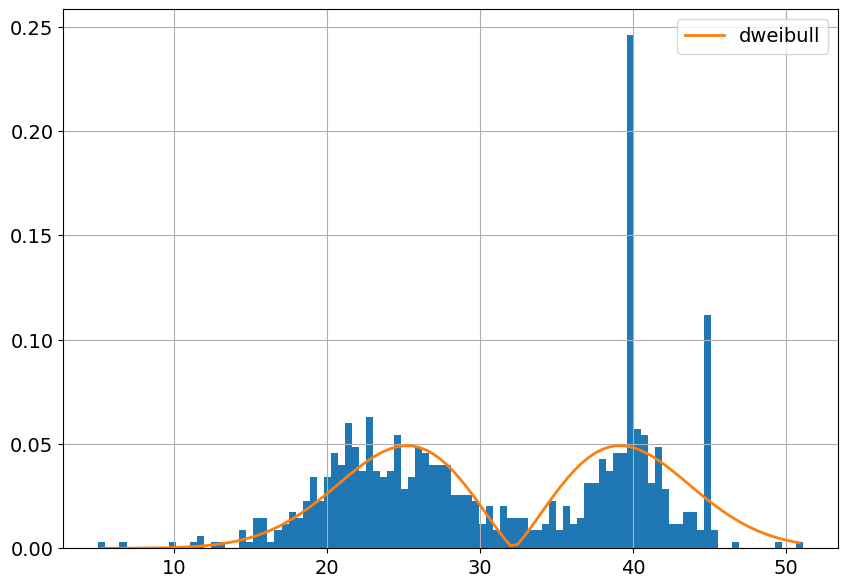

404 samples out of 42325 values


Fitting 111 distributions: 100%|█████████████████████████████████████████████████████| 111/111 [01:39<00:00,  1.12it/s]


The most suitable distribution for avg_price in Original dataset



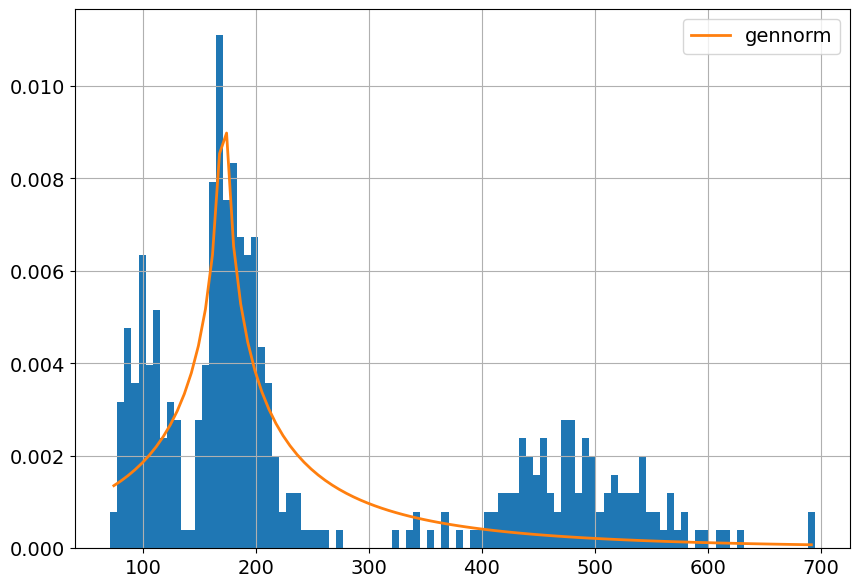

759 samples out of 846 values


Fitting 111 distributions: 100%|█████████████████████████████████████████████████████| 111/111 [06:05<00:00,  3.29s/it]


The most suitable distribution for avg_price in Test dataset



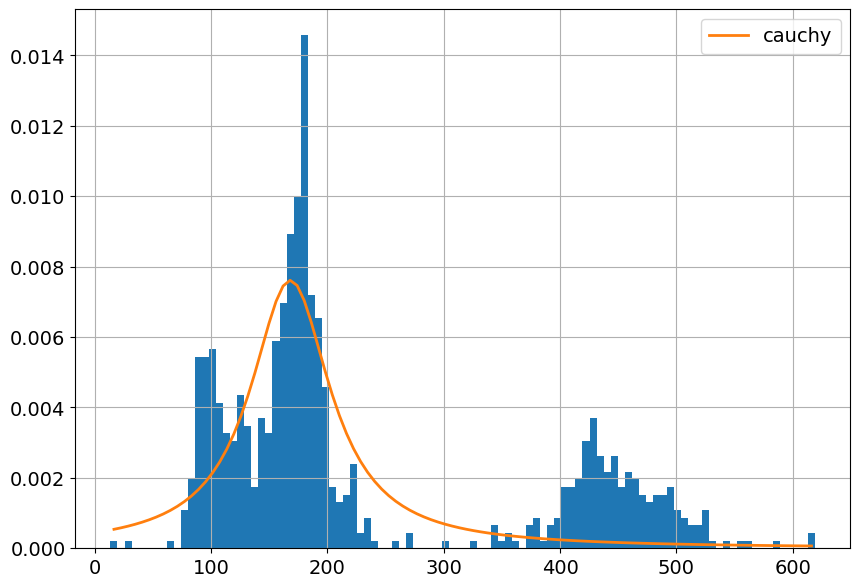

404 samples out of 42325 values


Fitting 111 distributions: 100%|█████████████████████████████████████████████████████| 111/111 [02:23<00:00,  1.29s/it]


The most suitable distribution for tickets in Original dataset



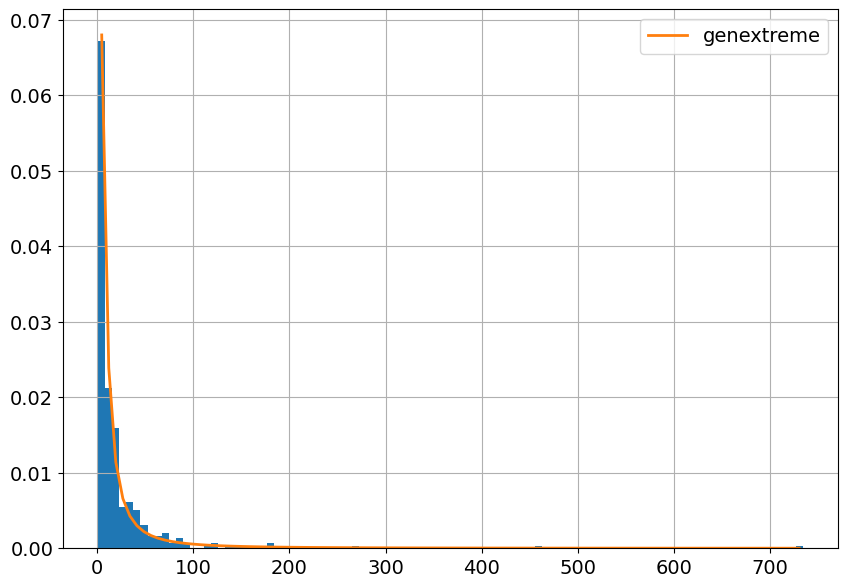

759 samples out of 846 values


Fitting 111 distributions: 100%|█████████████████████████████████████████████████████| 111/111 [06:14<00:00,  3.38s/it]


The most suitable distribution for tickets in Test dataset



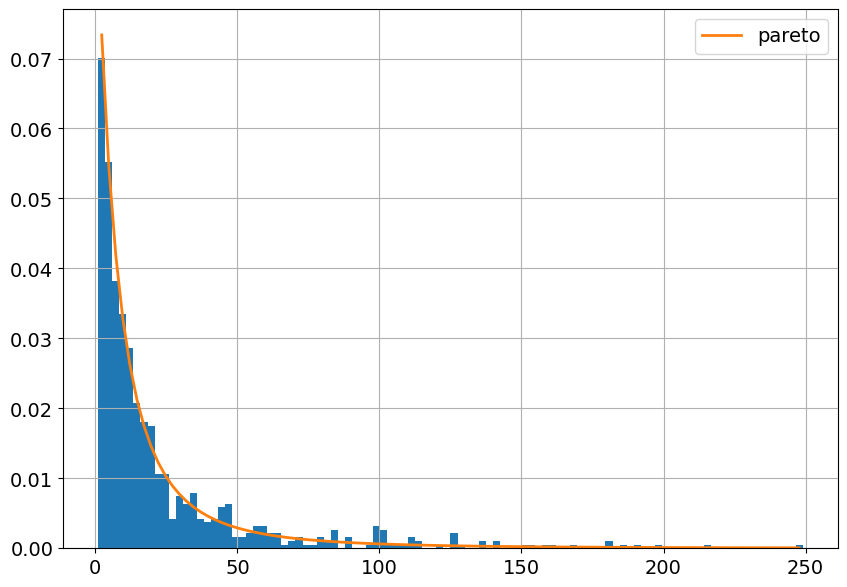

404 samples out of 42325 values


Fitting 111 distributions: 100%|█████████████████████████████████████████████████████| 111/111 [03:16<00:00,  1.77s/it]


The most suitable distribution for qty in Original dataset



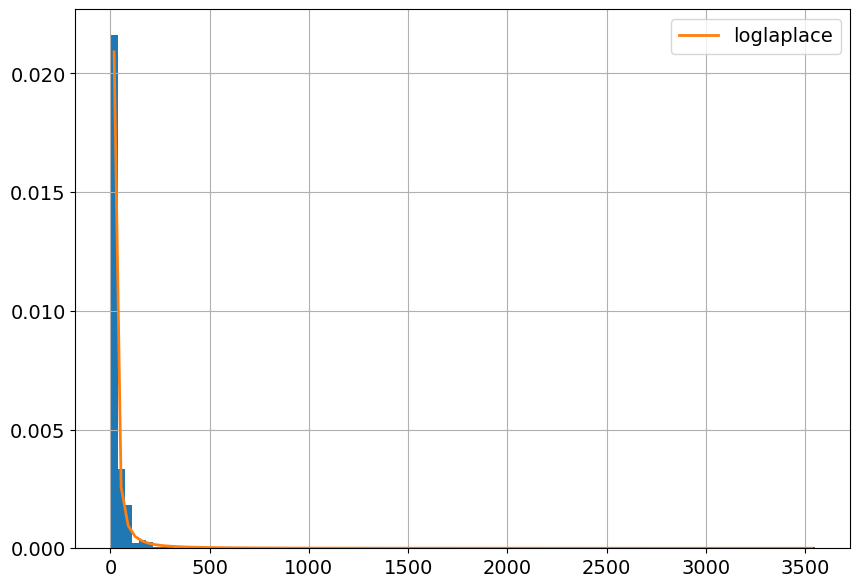

759 samples out of 846 values


Fitting 111 distributions: 100%|█████████████████████████████████████████████████████| 111/111 [06:24<00:00,  3.47s/it]


The most suitable distribution for qty in Test dataset



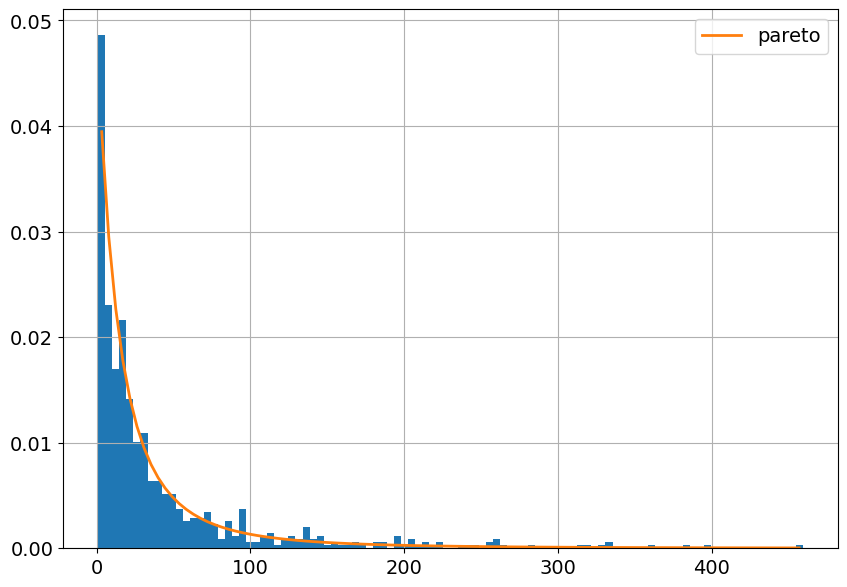

404 samples out of 42325 values


Fitting 111 distributions: 100%|█████████████████████████████████████████████████████| 111/111 [04:10<00:00,  2.25s/it]


The most suitable distribution for clients_qty in Original dataset



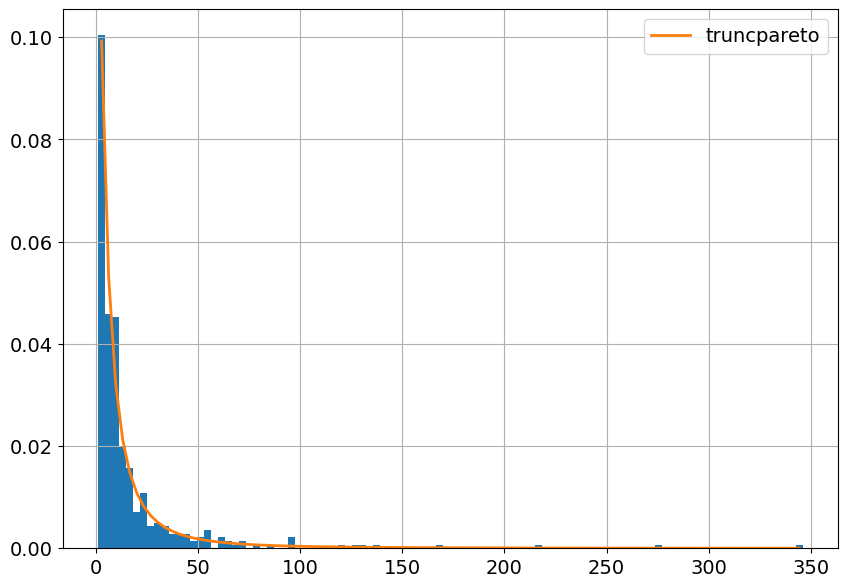

759 samples out of 846 values


Fitting 111 distributions: 100%|█████████████████████████████████████████████████████| 111/111 [06:31<00:00,  3.53s/it]


The most suitable distribution for clients_qty in Test dataset



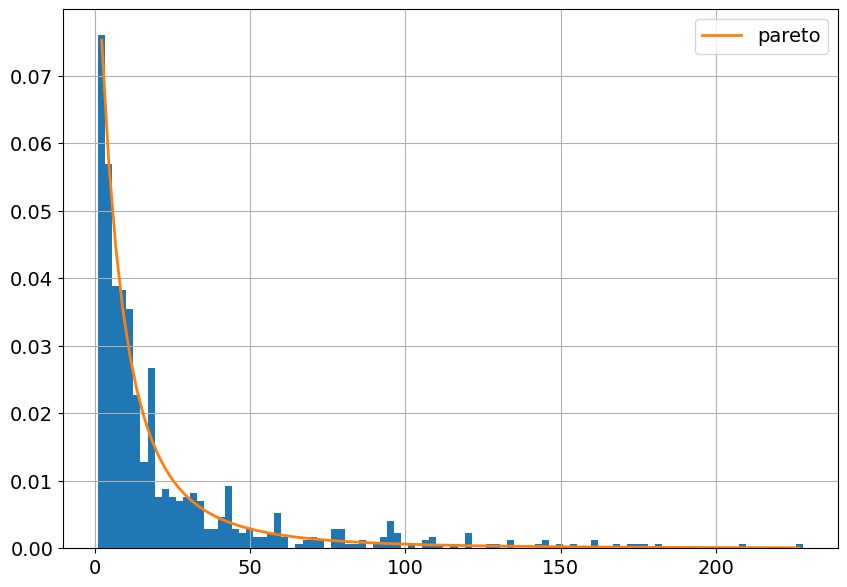

404 samples out of 42325 values


Fitting 111 distributions: 100%|█████████████████████████████████████████████████████| 111/111 [04:40<00:00,  2.53s/it]


The most suitable distribution for rto in Original dataset



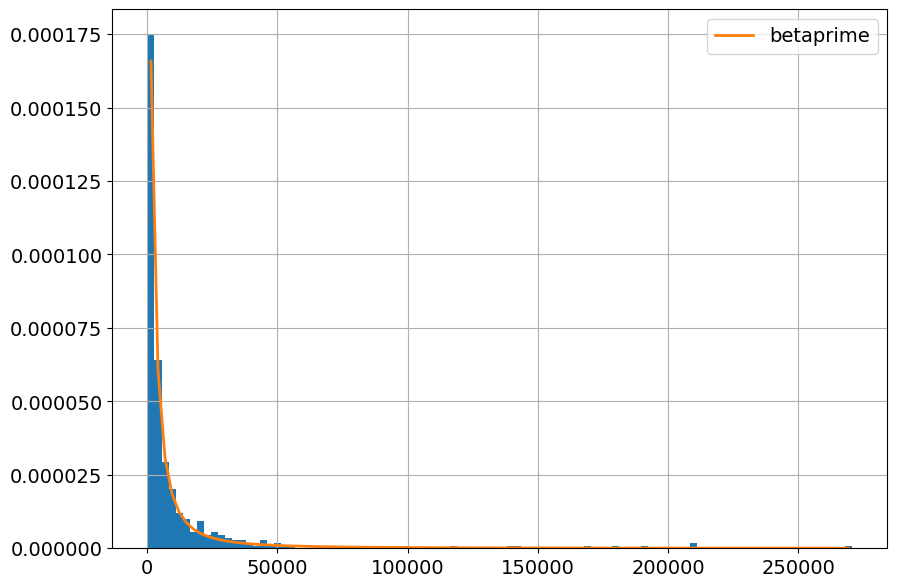

759 samples out of 846 values


Fitting 111 distributions: 100%|█████████████████████████████████████████████████████| 111/111 [06:44<00:00,  3.64s/it]


The most suitable distribution for rto in Test dataset



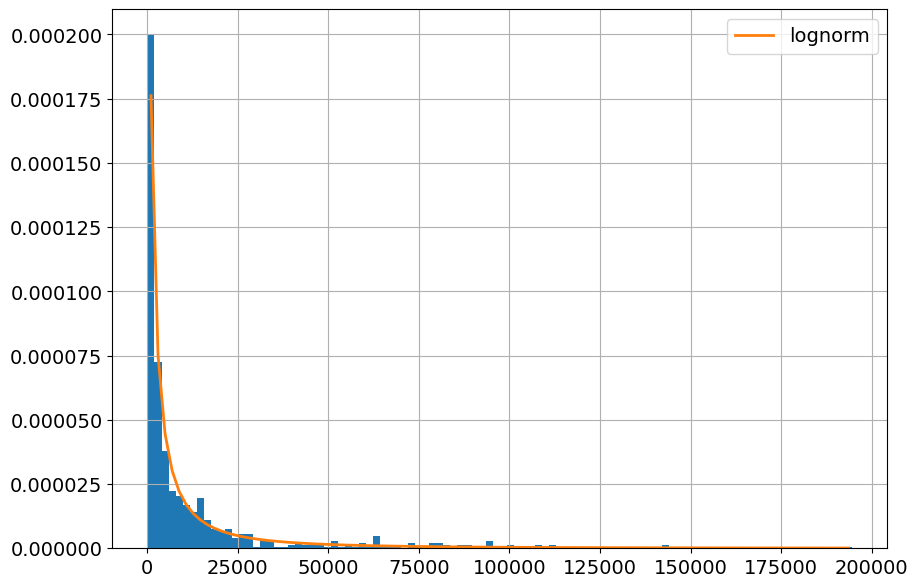

404 samples out of 42325 values


Fitting 111 distributions: 100%|█████████████████████████████████████████████████████| 111/111 [04:30<00:00,  2.43s/it]


The most suitable distribution for rto_do in Original dataset



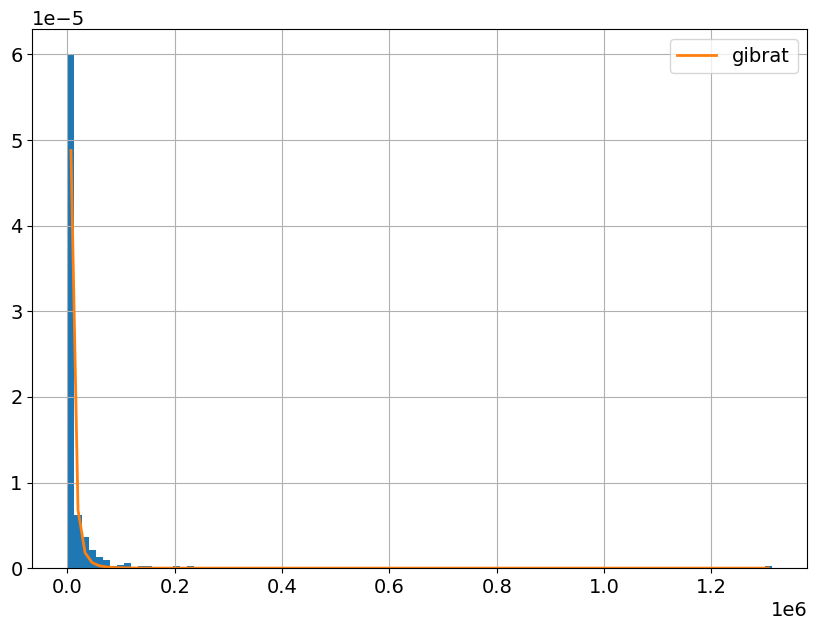

759 samples out of 846 values


Fitting 111 distributions: 100%|█████████████████████████████████████████████████████| 111/111 [06:56<00:00,  3.76s/it]


The most suitable distribution for rto_do in Test dataset



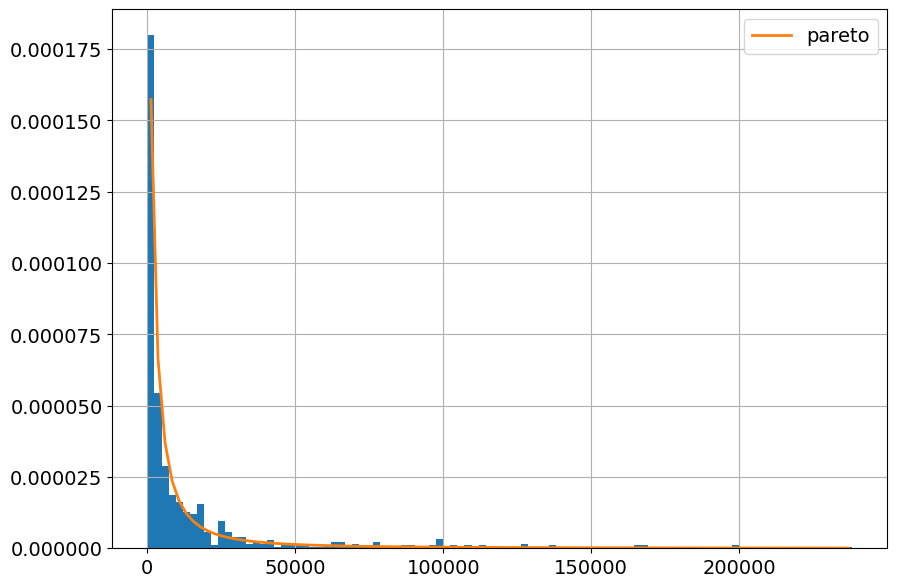

404 samples out of 42325 values


Fitting 111 distributions: 100%|█████████████████████████████████████████████████████| 111/111 [03:40<00:00,  1.98s/it]


The most suitable distribution for cost in Original dataset



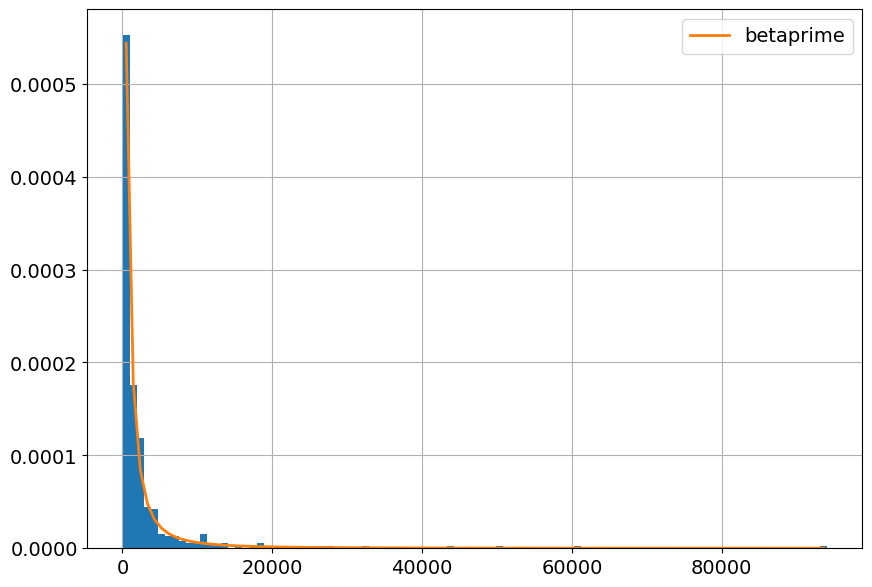

759 samples out of 846 values


Fitting 111 distributions: 100%|█████████████████████████████████████████████████████| 111/111 [07:05<00:00,  3.83s/it]


The most suitable distribution for cost in Test dataset



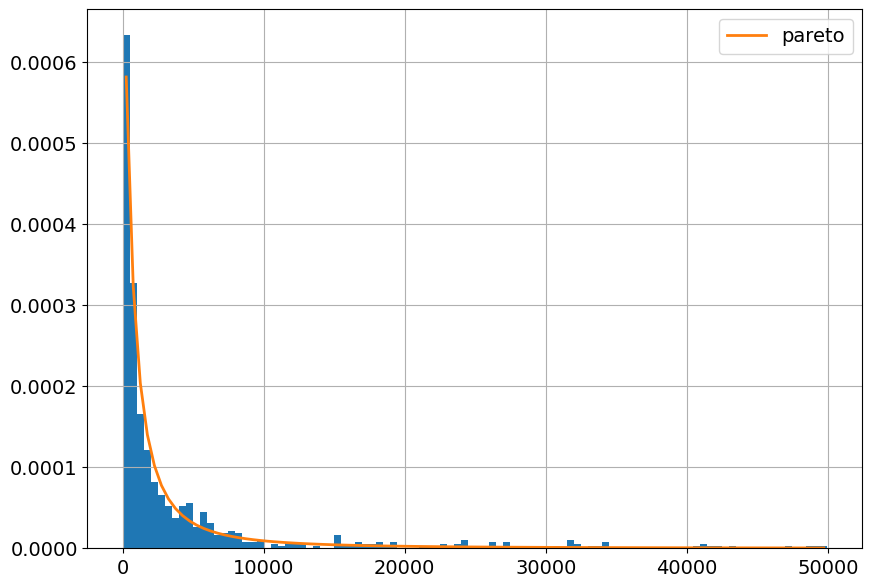

In [7]:
#b). What are the distributions in the data?

t = 2
a = 0.95
w = 0.5
e = 0.05

sample_values = []

def plt_hist(data, column_name):
    N = len(data[data.OrderSource == 'web'][column_name].values)
    n = round(abs((N*(t*t)*w*(w-1)) / ((e*e)*N + ((t*t)*w*(w-1)))))
    sample_values.append([data.name, n])
    print(f'{n} samples out of {N} values')
    data_ = random.sample(list(data[data.OrderSource == 'web'][column_name].values), n)  # https://bstudy.net/672834/sotsiologiya/raschet_neobhodimoy_chislennosti_vyborki
    f = Fitter(data_, distributions=get_distributions())
    f.fit()
    print(f'The most suitable distribution for {column_name} in {data.name}\n')
    df_ = pd.DataFrame(f.summary(Nbest=1, plot=True, method='sumsquare_error', clf=True))
    plt.show()

for j in variable:
    for i in [df, df_test]:
        plt_hist(data=i, column_name = j)

## Q:
3. How can you evaluate the effect of the test? If you know several methods, implement one and describe the others in writing.

You need to make a decision/give recommendations to leave everything as is or roll out a test version to the entire network or part of it.

## A:
Hypotheses:

H0 - the average value of the characteristic in the samples is the same

HA - the average value of the characteristic in the samples does not match

Other tests for large samples:
For example, Student's test (t-test assuming equal variances)

The number of tickets (orders) has increased, rto (revenue) has increased, the average price (avg_price) has decreased slightly, the average session time (avg_time) has decreased => it makes sense to roll out a test version of the web part of the network.

In [10]:
# A: We determined that there are enough n1 samples for the original data and n2 samples for the test ones.
n1 = sample_values[0][1]
n2 = sample_values[1][1]
data1 = df
data2 = df_test

def t_test_(data1, data2, column_name, n1, n2):
    t_ = stats.ttest_ind((random.sample(list(data1[data1.OrderSource == 'web'][column_name].values), n1)), (random.sample(list(data2[data2.OrderSource == 'web'][column_name].values), n2)), axis=0, equal_var=False)
    if t_.pvalue < 0.05:
        list_values.append([column_name, t_.pvalue, "H0"])
    else:
        list_values.append([column_name, t_.pvalue, "HA"])

list_values = []
for j in variable:
    t_test_(df, df_test,j, n1, n2)
    
#HA - enough data to say that the sample means are not the same
list_values

[['avg_time', 8.89668385461194e-05, 'H0'],
 ['avg_price', 0.001867017227922287, 'H0'],
 ['tickets', 0.6251750457660119, 'HA'],
 ['qty', 0.12244017517825084, 'HA'],
 ['clients_qty', 0.8805178646147079, 'HA'],
 ['rto', 0.0001845976049970892, 'H0'],
 ['rto_do', 0.18931207161482433, 'HA'],
 ['cost', 0.662866968431916, 'HA']]

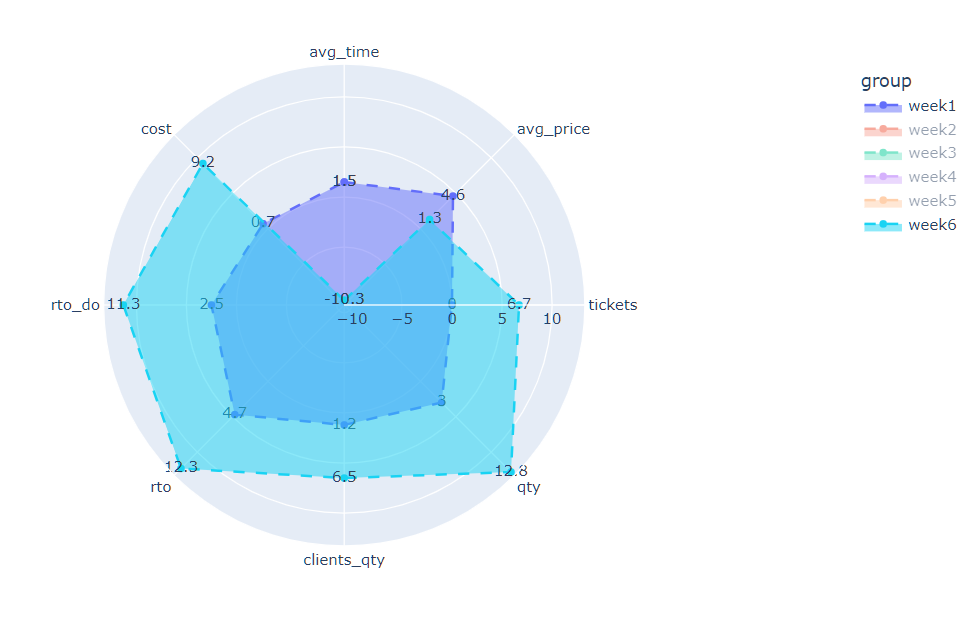

## Q:
4. Speculate in writing what metrics could still be assessed if all the company data were available to you.

## A:
Behavioral metrics can be assessed, namely:
1) Conversion (login to the application -> purchase), because the application design has not changed,
Only the ranking order of the product has changed, it is possible that the results may exceed expectations and a change in design, for example, will not be necessary. Or, perhaps, advertising was purchased, so there were more orders, but the conversion rate was lower.

2) Audience retention, including how many days in a row a person ordered product on average (you can average it per week)